In [1]:
from torchvision import datasets
import torchvision
from torchvision.transforms import transforms
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch
from tqdm import tqdm
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

2024-03-12 07:42:50.893436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 07:42:50.893545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 07:42:51.024138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import pandas as pd
from PIL import Image 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
## dataloader
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 19326061.70it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302579.32it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5579397.13it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8467559.60it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



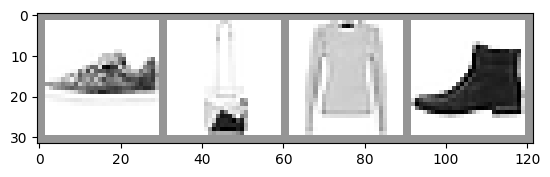

In [4]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 0.5 + 0.5   
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [5]:
class MultiClassCNN(nn.Module):
    def __init__(self):
        super(MultiClassCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4) ##
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = MultiClassCNN()

In [23]:
criterion = nn.CrossEntropyLoss() ##CrossEntropyLoss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() ##
        optimizer.step() ##
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 ## batch hight or low
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [24]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0
patience=2
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    running_vloss = 0.0
    model.eval()

    with torch.no_grad(): ##
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss ##
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
        count=0
    else:
        count += 1

    if count >= patience:
        print(f'No improvement for {patience} epoch')
        break

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.2332864549266035
  batch 2000 loss: 0.2587024845105035
  batch 3000 loss: 0.2312976017852211
  batch 4000 loss: 0.2511323260681217
  batch 5000 loss: 0.22212371619975937
  batch 6000 loss: 0.23271124109514996
  batch 7000 loss: 0.23729600527892677
  batch 8000 loss: 0.22598186560250647
  batch 9000 loss: 0.2544176283472418
  batch 10000 loss: 0.26658066192289004
  batch 11000 loss: 0.24643024385133036
  batch 12000 loss: 0.24032947858885456
  batch 13000 loss: 0.29728199977467884
  batch 14000 loss: 0.2548427067643542
  batch 15000 loss: 0.2727505277350863
LOSS train 0.2727505277350863 valid 0.3780848979949951
EPOCH 2:
  batch 1000 loss: 0.24034443131003486
  batch 2000 loss: 0.24070554615705678
  batch 3000 loss: 0.22087804879630563
  batch 4000 loss: 0.2548673288778374
  batch 5000 loss: 0.23071396038014147
  batch 6000 loss: 0.251014401462186
  batch 7000 loss: 0.28210510099046315
  batch 8000 loss: 0.22118031819485212
  batch 9000 loss: 0.2613490297742

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

new_image_path = "/kaggle/input/d/qnkhuat/fashionmnist/data/test/Dress/1009.jpg"
new_image = Image.open(new_image_path)
new_image = transform(new_image)
new_image = new_image.unsqueeze(0)

In [22]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

with torch.no_grad():
    predictions = model(new_image)
predicted_class = class_names[torch.argmax(predictions, dim=1).item()]
print(f"Predicted Class: {predicted_class}")

Predicted Class: Dress
